# Homework06

Exercises to practice pandas, data analysis and regression

## Goals

- Understand the effects of pre-processing data
- Get familiar with the ML flow: encode -> normalize -> train -> evaluate
- Understand the difference between regression and classification tasks
- Build an intuition for different regression models

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [6]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder

from data_utils import object_from_json_url
from data_utils import StandardScaler
from data_utils import LinearRegression, SGDRegressor
from data_utils import regression_error

### Load Dataset

Let's load up the full [ANSUR](https://www.openlab.psu.edu/ansur2/) dataset that we looked at briefly in [Week 02](https://github.com/DM-GY-9103-2024F-H/WK02).

This is the dataset that has anthropometric information about U.S. Army personnel.

In [8]:
# Load Dataset
ANSUR_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

# Look at first 2 records
ansur_data[:2]

[{'age': 18,
  'gender': 'F',
  'height': 66,
  'weight': 135,
  'span': 1699,
  'stature': 1645,
  'ear': {'breadth': 30, 'length': 61, 'protrusion': 20},
  'foot': {'breadth': 97, 'length': 243},
  'hand': {'breadth': 78, 'length': 182, 'palm': 108},
  'head': {'height': 243, 'circumference': 557}},
 {'age': 30,
  'gender': 'M',
  'height': 68,
  'weight': 207,
  'span': 1749,
  'stature': 1715,
  'ear': {'breadth': 35, 'length': 63, 'protrusion': 17},
  'foot': {'breadth': 100, 'length': 252},
  'hand': {'breadth': 87, 'length': 184, 'palm': 114},
  'head': {'height': 238, 'circumference': 560}}]

#### Nested data

This is that *nested* dataset from Week 02.

# 🤔

Let's load it into a `DataFrame` to see what happens.

In [9]:
# Read into DataFrame
ansur_df = pd.DataFrame.from_records(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear,foot,hand,head
0,18,F,66,135,1699,1645,"{'breadth': 30, 'length': 61, 'protrusion': 20}","{'breadth': 97, 'length': 243}","{'breadth': 78, 'length': 182, 'palm': 108}","{'height': 243, 'circumference': 557}"
1,30,M,68,207,1749,1715,"{'breadth': 35, 'length': 63, 'protrusion': 17}","{'breadth': 100, 'length': 252}","{'breadth': 87, 'length': 184, 'palm': 114}","{'height': 238, 'circumference': 560}"
2,27,M,67,121,1684,1657,"{'breadth': 36, 'length': 59, 'protrusion': 24}","{'breadth': 92, 'length': 251}","{'breadth': 84, 'length': 180, 'palm': 103}","{'height': 239, 'circumference': 516}"
3,20,M,73,185,1878,1828,"{'breadth': 36, 'length': 60, 'protrusion': 21}","{'breadth': 104, 'length': 280}","{'breadth': 95, 'length': 201, 'palm': 124}","{'height': 270, 'circumference': 582}"
4,33,M,76,150,1977,1883,"{'breadth': 39, 'length': 65, 'protrusion': 27}","{'breadth': 101, 'length': 271}","{'breadth': 90, 'length': 194, 'palm': 113}","{'height': 254, 'circumference': 559}"



# 😓🙄

That didn't work too well. We ended up with objects in our columns.

Luckily, our `DataFrame` library has a function called [`json_normalize()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html) that can help.

In [10]:
# Read into DataFrame
ansur_df = pd.json_normalize(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,F,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,M,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,M,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,M,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,M,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559


Much better. `DataFrames` are magic.

#### Data Exploration

Before we start creating models, let's do a little bit of data analysis and get a feeling for the shapes, distributions and relationships of our data.

1. Print `min`, `max` and `average` values for all of the features.
2. Print `covariance` tables for `age`, `ear.length` and `head.circumference`.
3. Plot `age`, `ear.length` and `head.circumference` versus the $1$ *feature* that is most correlated to each of them.

Don't forget to *encode* and *normalize* the data.

age
	min: 17
	max: 58
	avg: 29.74535714285714
gender
	min: 0
	max: 1
	avg: 0.3273214285714286
height
	min: 56
	max: 94
	avg: 68.24732142857142
weight
	min: 0
	max: 321
	avg: 174.55839285714285
span
	min: 1323
	max: 2121
	avg: 1763.703392857143
stature
	min: 1409
	max: 1993
	avg: 1714.265357142857
ear.breadth
	min: 25
	max: 46
	avg: 35.128928571428574
ear.length
	min: 46
	max: 81
	avg: 62.637142857142855
ear.protrusion
	min: 13
	max: 34
	avg: 22.266785714285714
foot.breadth
	min: 77
	max: 126
	avg: 98.85089285714285
foot.length
	min: 198
	max: 323
	avg: 262.9919642857143
hand.breadth
	min: 67
	max: 105
	avg: 84.93696428571428
hand.length
	min: 145
	max: 239
	avg: 189.26017857142858
hand.palm
	min: 88
	max: 140
	avg: 113.91964285714286
head.height
	min: 206
	max: 295
	avg: 249.17089285714286
head.circumference
	min: 502
	max: 635
	avg: 570.0628571428572
weight


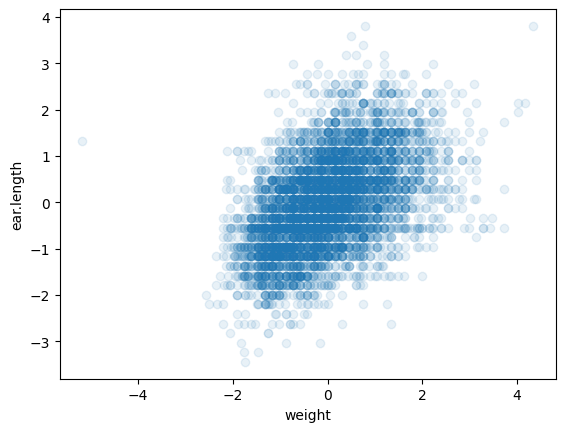

hand.breadth


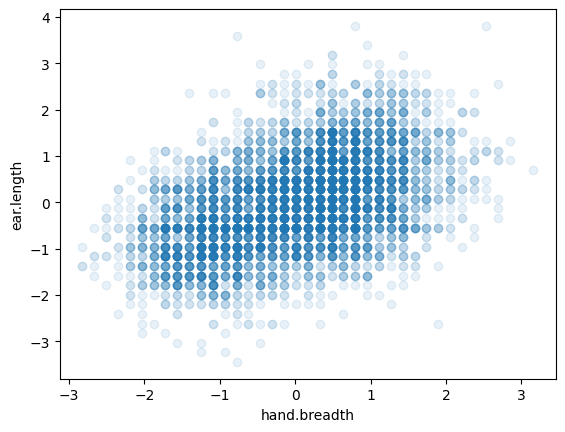

ear.breadth


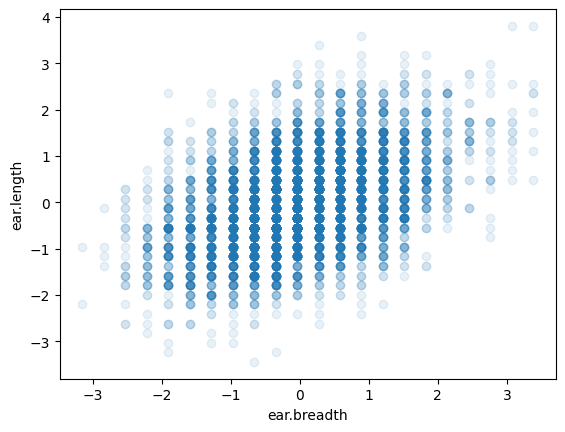

weight


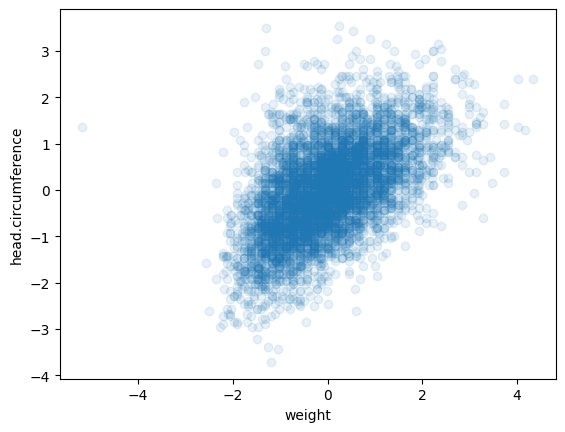

foot.length


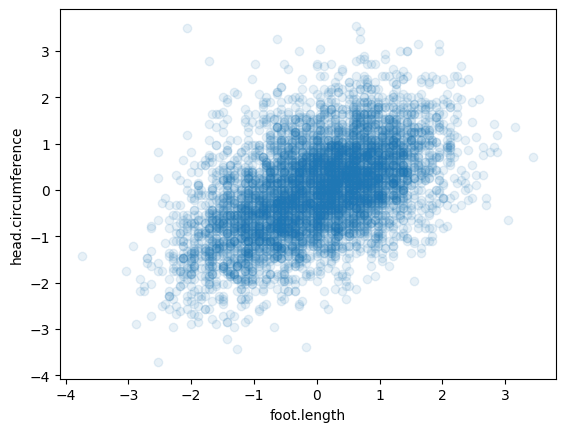

head.height


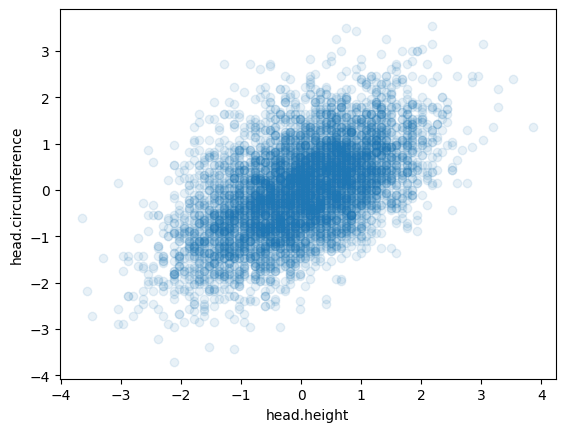

weight


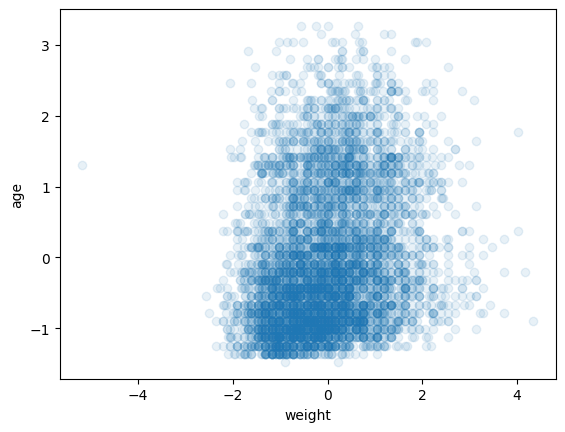

ear.length


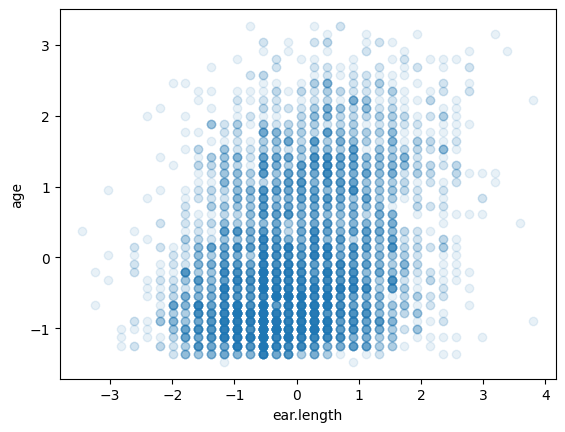

ear.breadth


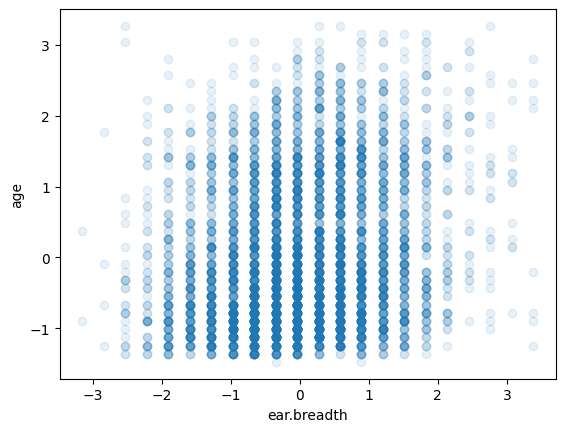

In [11]:
# Work on Data Exploration here
#print(ansur_df)
### Encode non-numerical features
#gender_order = ["M", "F"]
#gender_encoder = OrdinalEncoder(categories=[gender_order])

# Encode the columns
#gender_vals = gender_encoder.fit_transform(ansur_df[["gender"]].values)

# Put the values back in the original DataFrame
#ansur_df[["gender"]] = gender_vals
ansur_df['gender'] = ansur_df['gender'].map({'M': 0, 'F': 1})
#print(ansur_df)

## 1. Print min, max, avg

for f in ansur_df.columns:
  print(f)
  print("\tmin:", ansur_df[f].min())
  print("\tmax:", ansur_df[f].max())
  print("\tavg:", ansur_df[f].mean())

### Normalize all data

# Create a scaler object
std_scaler = StandardScaler()

# Use the object on our data
ansur_scaled_df = std_scaler.fit_transform(ansur_df)

# Scaled version of DataFrame
#ansur_scaled_df.head()


## 2. Print Covariances
ansur_scaled_df.cov()


## 3. Plot features most correlated to age, ear length and head circumference

ansur_scaled_df.cov()[["ear.length", "age", "head.circumference"]]

#Select the three largest values for each category
highest_cov_el = ansur_scaled_df.cov()[["ear.length"]].apply(lambda col: col.nlargest(4))
highest_cov_a = ansur_scaled_df.cov()[["age"]].apply(lambda col: col.nlargest(4))
highest_cov_hc = ansur_scaled_df.cov()[["head.circumference"]].apply(lambda col: col.nlargest(4))

#print(highest_cov_el)

##I manually entered the values in each one of the following arrays for simplicity. 
highest_cov_el_vals = ["weight", "hand.breadth", "ear.breadth"]

highest_cov_a_vals = ["weight", "ear.length", "ear.breadth"]

highest_cov_hc_vals = ["weight", "foot.length", "head.height"]

for f in highest_cov_el_vals:
  print(f)
  plt.scatter(ansur_scaled_df[f], ansur_scaled_df["ear.length"], alpha=.1)
  plt.xlabel(f)
  plt.ylabel("ear.length")
  plt.show()


for f in highest_cov_hc_vals:
  print(f)
  plt.scatter(ansur_scaled_df[f], ansur_scaled_df["head.circumference"], alpha=.1)
  plt.xlabel(f)
  plt.ylabel("head.circumference")
  plt.show()

for f in highest_cov_a_vals:
  print(f)
  plt.scatter(ansur_scaled_df[f], ansur_scaled_df["age"], alpha=.1)
  plt.xlabel(f)
  plt.ylabel("age")
  plt.show()






### Interpretation

<span style="color:hotpink;">
Does anything stand out about these graphs? Or the correlations?<br>
Are correlations symmetric? Does the feature most correlated to ear length also have ear length as its most correlated pair?



</span>

<span style="color:hotpink;">I am seeing positive correlations between certain features that make me believe some body parts have a distinctive shape, or that the ratio of one part vs another is a constant or tends to be a constant. For example, ear length and ear breadth, or head circumference and head height. This could be true to the body as a whole, since head circumference and foot length, for example, are also positively correlated, which means the bigger the head, the more likely it is to have a longer foot. The same happens with weight and other variables, like head circumference and ear length, which I interpret as the higher the weight, the more likely it is to have a person with bigger features in general. Also, everything gets bigger as we grow older, so the earlier years show positive correlation with weight, and both breadth and length of the ears, which makes sense. 
I wonder if a deep study with real data about people measurements and how they evolve in time can help us predict human growth and even determine the age of humans or even mummies, like when we know, for example, how old horse is by looking at some features, like the teeth. At the same time, it seems like there are too many variables involved, and perhaps not all of them might be represented by the data captured, however vast it may seem, so I also think of the challenges of being a data scientist and justifying the validity of the claims and assumptions made in the work. 
</span>

### Regression

Now, we want to create a regression model to predict `head.circumference` from the data.

From our [Week 06](https://github.com/PSAM-5020-2025S-A/WK06) notebook, we can create a regression model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (done! ⚡️)
3. Normalize the data (done! 🍾)
4. Separate the outcome variable and the input features
5. Create a regression model using all features
6. Run model on training data and measure error
7. Plot predictions and interpret results
8. Run model on test data, measure error, plot predictions, interpret results

['age', 'gender', 'height', 'weight', 'span', 'stature', 'ear.breadth', 'ear.length', 'ear.protrusion', 'foot.breadth', 'foot.length', 'hand.breadth', 'hand.length', 'hand.palm', 'head.height', 'head.circumference']
age


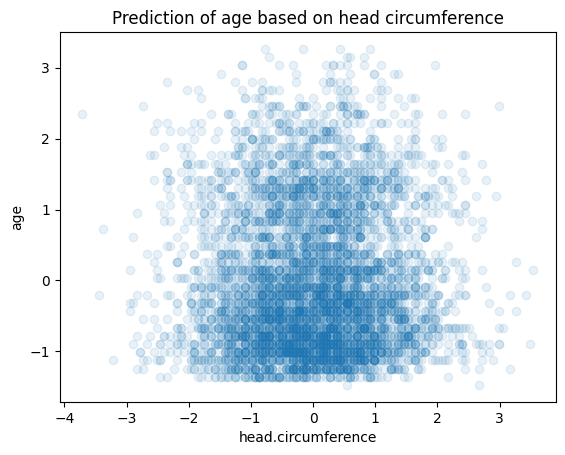

gender


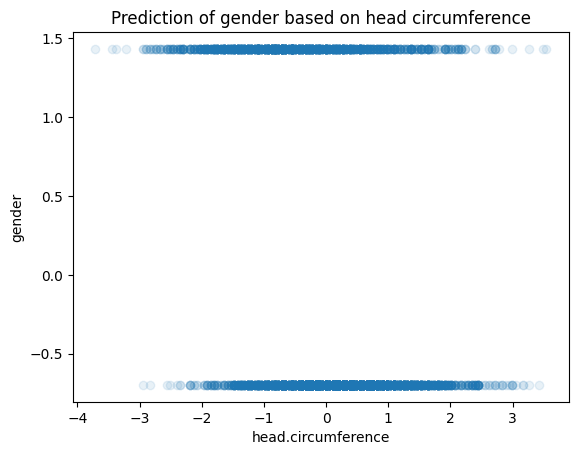

height


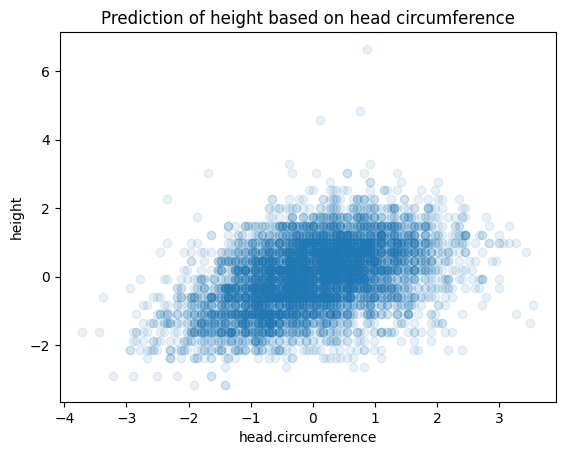

weight


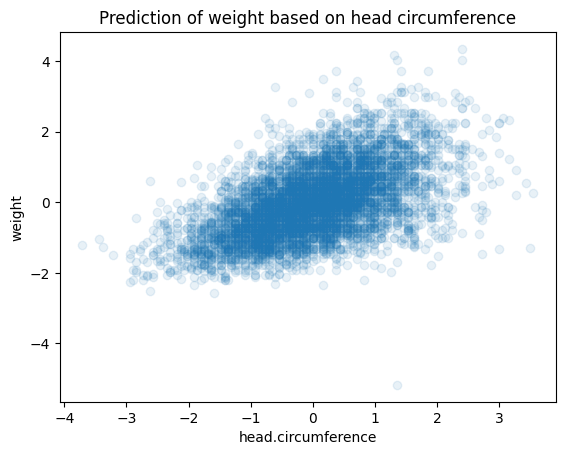

span


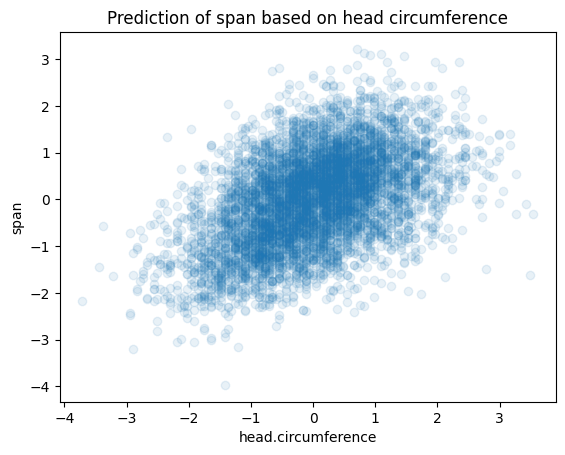

stature


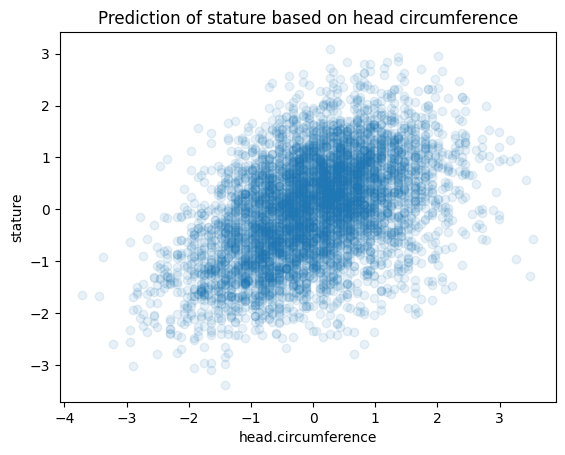

ear.breadth


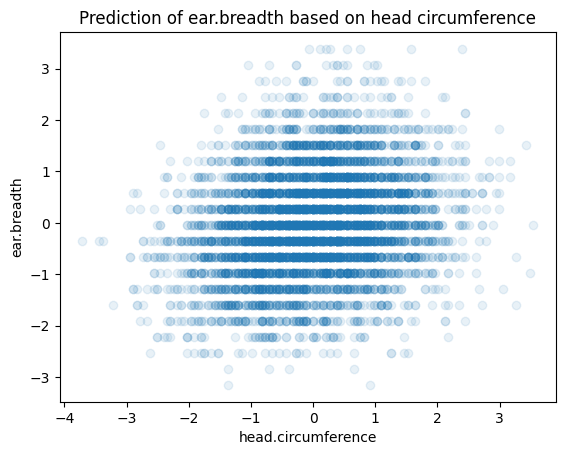

ear.length


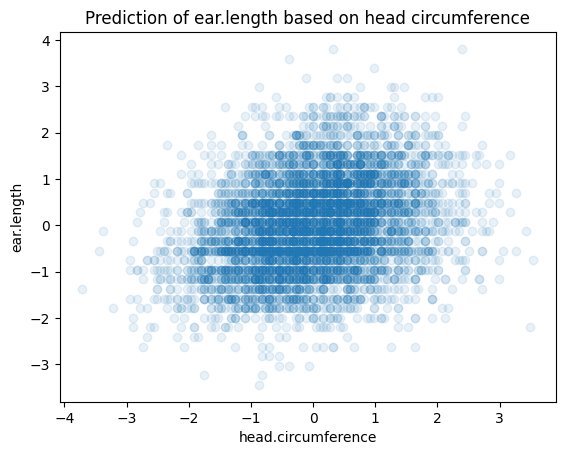

ear.protrusion


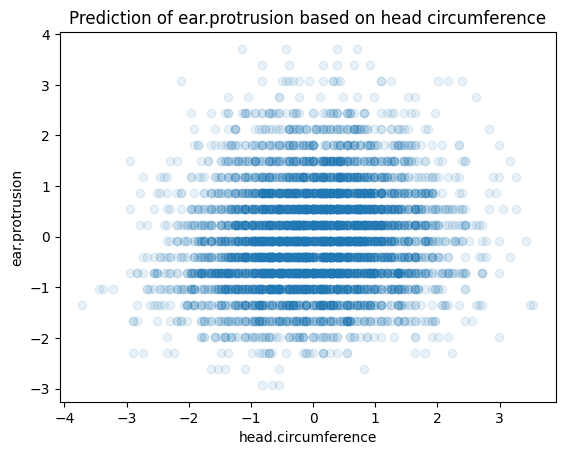

foot.breadth


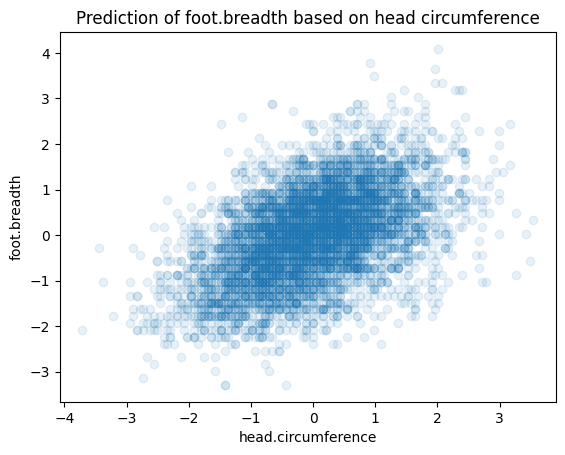

foot.length


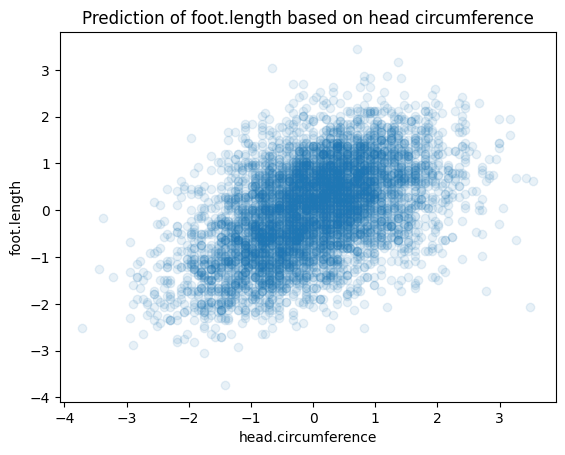

hand.breadth


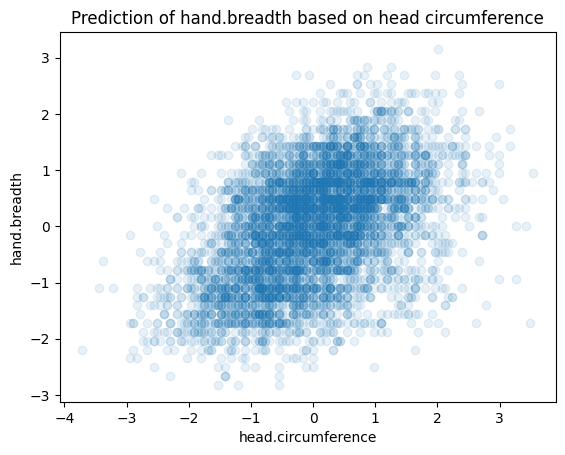

hand.length


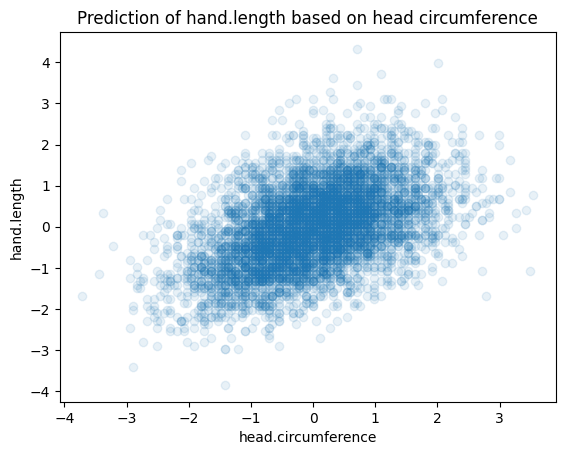

hand.palm


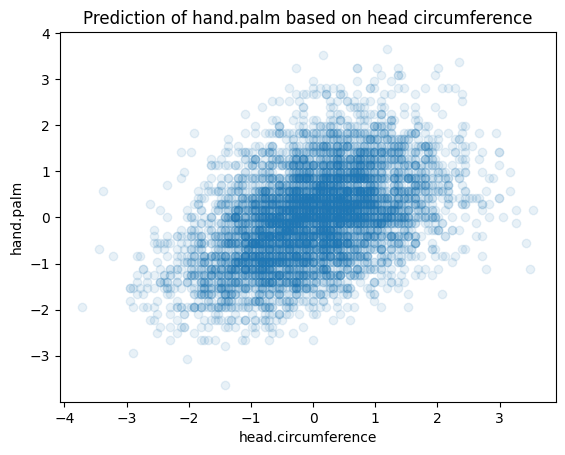

head.height


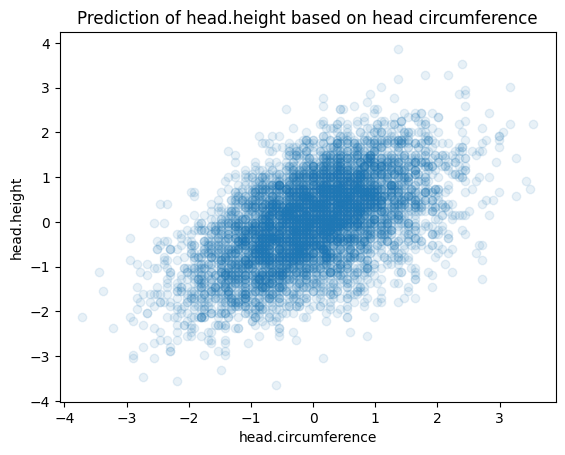

249.23110364701665

In [21]:
# Work on Regression Model here
features_ansur = [f for f in ansur_df.columns]
print(features_ansur)

## Separate outcome variable and input features

## Create a regression model

## Measure error on training data

## Plot predictions and interpret results

# TODO: train a Linear Regression predictor for sales based on month

# this can be exactly the same as the other cell above, as long as
# the new "periodic_month" feature is included in the data for the model


## 4. Separate the outcome variable and the independent variables

## 5. Create a LinearRegression object
model = LinearRegression()

# Use the object to create a model that relates sales amounts to month

## 6. Run the model on the training data


# Un-normalize the data

# Plot predictions
for f in ansur_scaled_df:
    if f == "head.circumference":
        continue  # Avoid using the same variable for X and y
    
    print(f)
    
    X = ansur_scaled_df[["head.circumference"]]  # Keep X as a DataFrame
    y = ansur_scaled_df[f]

    model.fit(X, y)  # Fit before predicting

    predicted_scaled = model.predict(X)  # No need to reshape since it's already 2D
    predicted = std_scaler.inverse_transform(predicted_scaled)

    plt.scatter(X, y, alpha=0.1)
    plt.xlabel("head.circumference")
    plt.ylabel(f)
    plt.title(f"Prediction of {f} based on head circumference")
    plt.show()

# Measure error
regression_error(ansur_scaled_df["head.circumference"], predicted)


In [ ]:
## Load Test Data
ANSUR_TEST_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/main/datasets/json/ansur-test.json"

ansur_test_data = object_from_json_url(ANSUR_TEST_FILE)
ansur_test_df = pd.json_normalize(ansur_test_data)

ansur_test_encoded_df = ansur_test_df.copy()

g_vals = ansur_encoder.transform(ansur_test_df[["gender"]].values)
ansur_test_encoded_df[["gender"]] = g_vals

ansur_test_scaled_df = ansur_scaler.transform(ansur_test_encoded_df)

In [ ]:
## Run model on test data

## Measure error on test data

## Plot predictions and interpret results

### Interpretation

<span style="color:hotpink;">
How well does your model perform?<br>
How could you improve it?<br>
Are there ranges of circumferences that don't get predicted well?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>